# Prediction

This project aims to explore and analyze data related to Bitcoin, focusing primarily on its value fluctuations and the factors influencing them. The primary objective is to develop a predictive model that accurately forecasts Bitcoin's future value based on historical data and other relevant indicators. This initial exploration is a crucial step in understanding the data's nature, trends, and potential challenges we might face in the modeling phase.

- Objectives of the Prediction Notebook:
    Experiment different machine learning techniques, models etc.. to generate a prediction of the Bitcoin's price.

# Importing libraries

In [225]:
# Importing essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler,RobustScaler
from keras.optimizers import Adam


from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from IPython.display import display


# Setting display options for better notebook readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Setting the style for matplotlib and seaborn for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')


## Loading Data

We will load 3 data files: external, global, by actor from the folders 2015 and task1.
- EXTERNAL : gives the variation of the price of Bitcoin by data coming directly from platforms, not from the blockchain.
- GLOBAL : gives a number of details about transactions, fees etc... 
- BY_ACTOR : a detailed version of global, each line for each actor.

The 2015 files contains the 7 days of each week (from 0 to 6)
while the task1 files doesn't contain the 7th day, but only weekdays from (0 to 5), the 6th should be predicted.


We'll use the folder 2015 to train the model.
And then, we'll use task1 to test and predict.


In [40]:
# Chemin d'accès aux fichiers de données
path_to_data = '../data/timeseries/2015/'

external_2015 = pd.read_csv(path_to_data + 'external.csv')
global_2015 = pd.read_csv(path_to_data + 'global.csv')
by_actor_2015 = pd.read_csv(path_to_data + 'by_actor.csv')

# Affichage des premières lignes pour un aperçu initial
print("External Data - First 5 Rows:")
external_2015.head()
print("/nBlockchain Global Data - First 5 Rows:")
global_2015.head()
print("/nBlockchain by Actor Data - First 5 Rows:")
by_actor_2015.head()


External Data - First 5 Rows:
/nBlockchain Global Data - First 5 Rows:
/nBlockchain by Actor Data - First 5 Rows:


,week,weekday,year,month,day,identity,received,nb_received,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
0,0,0,2015,1,2,0,34012156723,8395,15588104,1.88,962,34009374770,0,0,2068,34009374770
1,0,0,2015,1,2,35,50000000,1,42966,0.20,3,21707034,0,0,6,21707034
2,0,0,2015,1,2,57,54120689613,230,880706,1.75,86,22815001320,0,0,179,22815001320
3,0,0,2015,1,2,61,1561500012,79,120000,0.05,10,1002920134,0,0,20,1002920134
4,0,0,2015,1,2,107,31639115343,66,280000,0.02,31,29063152655,0,0,59,29063152655


# LSTM 
First of all, let's try to use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

## Preprocessing 

### Creation of sequences of 6 days to predict the 7th.

In [41]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    total_weeks = len(data) // (seq_length + 1)  # Nombre total de semaines

    for week in range(total_weeks):
        start_index = week * (seq_length + 1)
        x = data[start_index:(start_index + seq_length)]
        y = data[start_index + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 6  # 6 jours pour prédire le 7ème

### Displaying function to display the results

In [19]:
def show_results(predicted_prices, real_prices):
    # Affichage des résultats
    plt.figure(figsize=(12, 6))
    plt.plot(real_prices, label='Real Price')
    plt.plot(predicted_prices, label='Predicted Price')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    # Affichage des résultats avec des points
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(real_prices)), real_prices, label='Real Price', color='blue')
    plt.scatter(range(len(predicted_prices)), predicted_prices, label='Predicted Price', color='orange')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    comparison_df = pd.DataFrame({'Real Price': real_prices.flatten(), 'Predicted Price': predicted_prices.flatten()})
    display(comparison_df)
    mse = mean_squared_error(real_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real_prices, predicted_prices)
    r2 = r2_score(real_prices, predicted_prices)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R² Score: {r2}')

### Metrics
The metrics that we'll use here are : 
- MSE
- RMSE 
- MAE
- R2

### Defining the Train and test functions

In [42]:
def read_and_prepare_data(file_name):
    external_2015 = pd.read_csv(path_to_data + file_name)
    data = external_2015[['PriceUSD']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    X, y = create_sequences(data_scaled, 6)
    return X, y, scaler

def split_data(X, y, train_size_ratio=0.8):
    train_size = int(len(X) * train_size_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

def predict_and_inverse_transform(model, X_test, y_test, scaler):
    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(np.reshape(y_test, (-1, 1)))
    return predicted_prices, real_prices

def train_and_test_model(model, file_name):
    X, y, scaler = read_and_prepare_data(file_name)
    X_train, X_test, y_train, y_test = split_data(X, y)
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
    predicted_prices, real_prices = predict_and_inverse_transform(model, X_test, y_test, scaler)
    show_results(predicted_prices, real_prices)


### Building the model and testing it 

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0704 - val_loss: 0.0379
Epoch 2/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0600 - val_loss: 0.0309
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0504 - val_loss: 0.0246
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0416 - val_loss: 0.0189
Epoch 5/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0334 - val_loss: 0.0137
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0260 - val_loss: 0.0092
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0193 - val_loss: 0.0055
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0135 - val_loss: 0.0027
Epoch 9/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0087 - val_loss: 0.0010
Epoch 10/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0052 - val_loss: 5.2631e-04
Epoch 11/100
1/1 

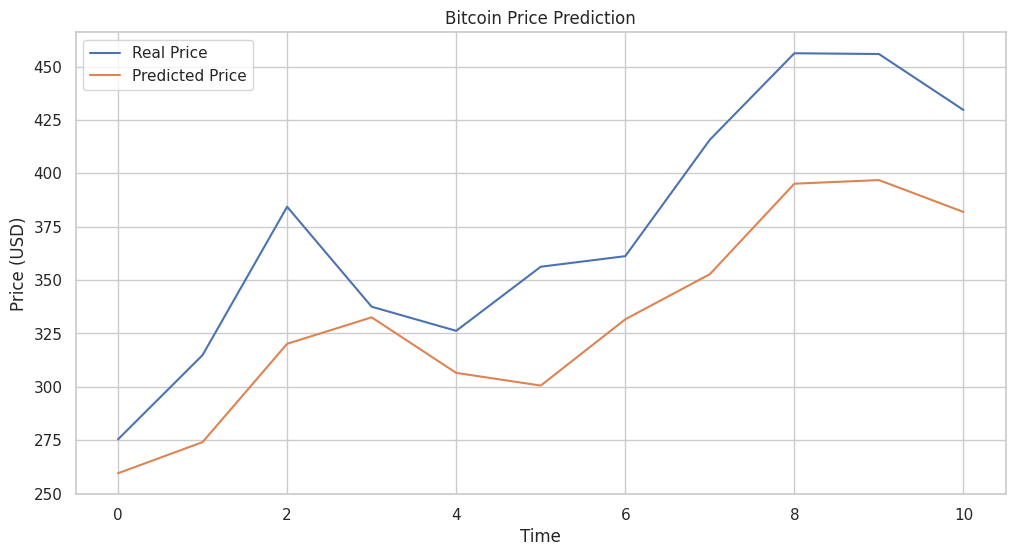

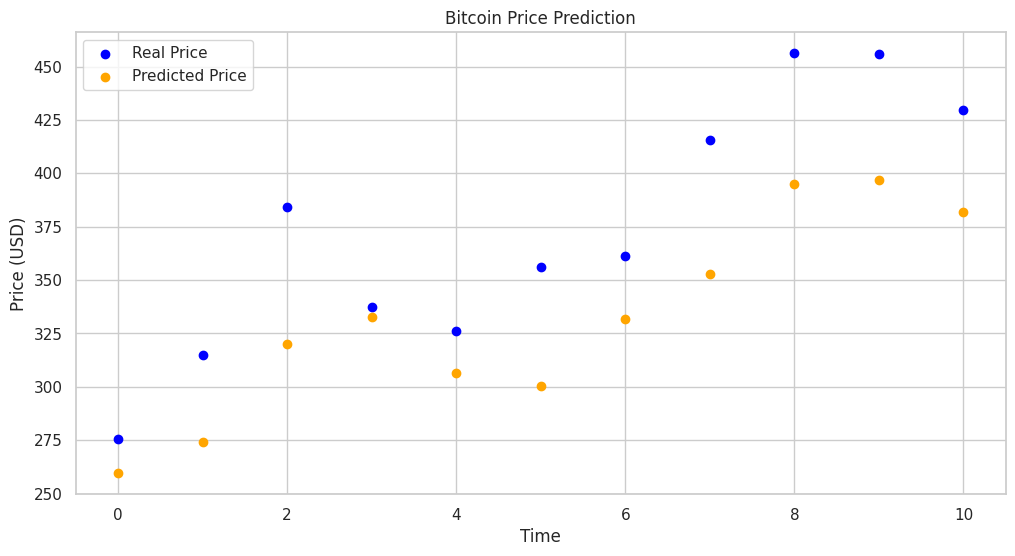

,Real Price,Predicted Price
0,275.41,259.53
1,314.88,274.11
2,384.34,320.16
3,337.52,332.55
4,326.23,306.54
5,356.26,300.60
6,361.21,331.64
7,415.73,352.77
8,456.24,395.15
9,455.88,396.84


Mean Squared Error (MSE): 2171.11362187652
Root Mean Squared Error (RMSE): 46.59521028900417
Mean Absolute Error (MAE): 41.96276412297578
R² Score: 0.33141984521819834


In [43]:
# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model,"external.csv")

As we can see, the prediction is quite good. And we are able to reach an acceptable loss, and MSE. The R squared score is a little bit low: 
But by looking into the data, we can see that the prices are not varying that much. that's why the R2 score is not that good.
Let's do some tests with a more fluctuent price.     

For this purpose, we duplicated the external file and added some fake prices, for instance we make the price go from 400 more or less to around 2000. Let's see if this will impact the performance of the model. 

So we created two variants of the external file : 
- external_outliers_in_test.csv : contains outliers values only in the part that will be used for the test (so in the 20% of the file since we are splitting it into 80% - 20%)
- external_outliers_in_train.csv : contains outliers values in the 80% that is the train part and in the 20% that is the test part.

By using these files we'll be able to study and watch out the behaviour of our models while they're facing different scenarios. 

## External Extended

### External with outliers in test set.

We'll now test our LSTM model that was pretty good on the external.csv , on our new file external_outliers_in_test.csv and follow its performance

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 9.7723e-04 - val_loss: 2.0480e-04
Epoch 2/100
1/1 [==============================] - 0s 46ms/step - loss: 4.3063e-04 - val_loss: 2.0372e-05
Epoch 3/100
1/1 [==============================] - 0s 52ms/step - loss: 1.3507e-04 - val_loss: 5.8103e-05
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 7.4427e-05 - val_loss: 2.3029e-04
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 1.7322e-04 - val_loss: 3.6355e-04
Epoch 6/100
1/1 [==============================] - 0s 46ms/step - loss: 2.7119e-04 - val_loss: 3.7670e-04
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 2.8158e-04 - val_loss: 3.0143e-04
Epoch 8/100
1/1 [==============================] - 0s 35ms/step - loss: 2.2480e-04 - val_loss: 1.9561e-04
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 1.4943e-04 - val_loss: 1.0220e-04
Epoch 10/100
1/1 [==============================

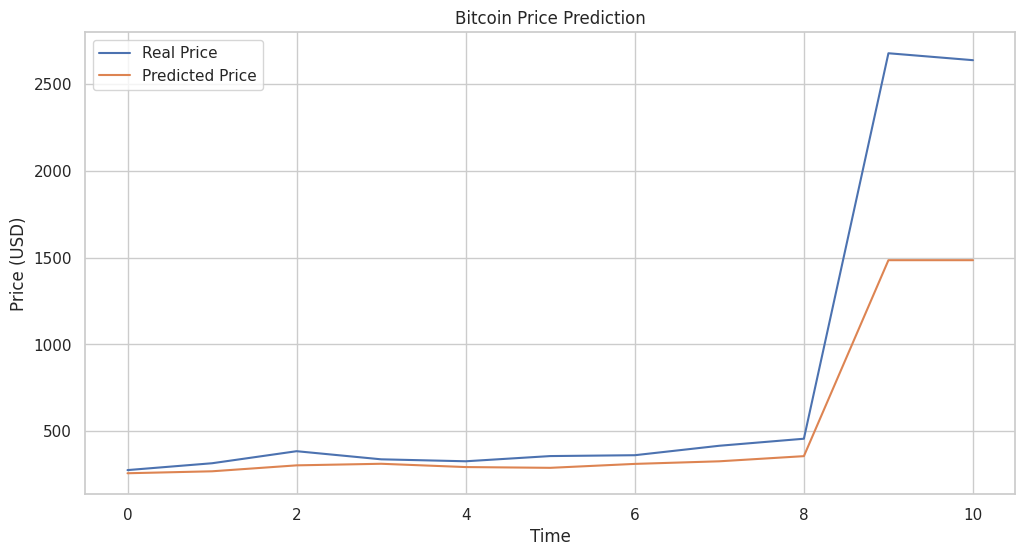

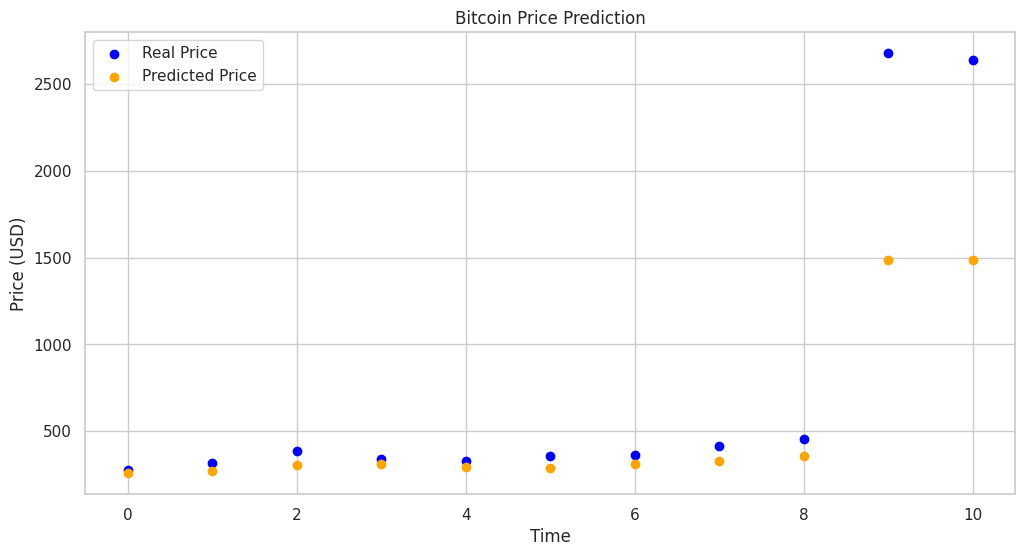

,Real Price,Predicted Price
0,275.41,257.19
1,314.88,268.48
2,384.34,302.71
3,337.52,311.85
4,326.23,292.85
5,356.26,288.45
6,361.21,311.11
7,415.73,326.10
8,456.24,355.79
9,2679.26,1485.91


Mean Squared Error (MSE): 253676.0921240365
Root Mean Squared Error (RMSE): 503.662676921803
Mean Absolute Error (MAE): 259.9982723118006
R² Score: 0.6787276569773266


In [44]:
# Construction du modèle LSTM
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model2,"external_outliers_in_test.csv")

The results obtained from testing the LSTM model on two different datasets – one with outliers and the other without – reveal interesting insights when looking at the Mean Absolute Error (MAE) and R² Score metrics.    
For the dataset containing outliers, we observe a higher MAE of 202.469, indicating that some predictions are significantly off from the actual values, a common occurrence in the presence of outliers. However, the R² Score is relatively high at 0.806, suggesting that the model is still able to explain the variance in the data. 
This high R² Score can occur even with a high MAE, especially in datasets with high variance due to outliers. 

On the other hand, in the dataset without outliers, the MAE is lower at 42.487, indicating that the predictions are generally closer to the actual values, as expected in outlier-free data. Yet, the R² Score drops to 0.311, implying that, despite more accurate predictions in terms of absolute error, the model explains a smaller proportion of the data's variance. This lower R² Score could be attributed to the overall lower variability in the dataset without outliers. 

These results highlight that MAE and R² Score measure different aspects of model performance. A higher MAE in the presence of outliers doesn't necessarily imply poor model performance in terms of variance explained, as indicated by the R² Score. It's crucial to consider both metrics together for a comprehensive understanding of the model's performance.

### External with outliers in train 

In [ ]:
# Construction du modèle LSTM
model3 = Sequential()
model3.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model3.add(LSTM(50))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model3,"external_outliers_in_train.csv")

Of course here, we have quite better results when we include the outliers in the train AND in the test part together. But let's see if we can make our model very performant on outliers even without training it on these outliers.

## Problem : 
  
We are encountering a common challenge in time series prediction, particularly when there are sudden changes or anomalies in the data. The issue arises when our LSTM model, trained on the 2015 Bitcoin price data, struggles to accurately predict prices during a test week where prices are significantly higher than those seen during the training period. Specifically, our model has been trained and tested on data where each sequence consists of 6 days used to predict the price on the 7th day.

In the 2015 dataset, the model performs well because the test set (20% of the data) closely resembles the training set (80% of the data). However, when we introduce a new week into the test set with substantially higher Bitcoin prices than previously seen, the model's prediction for the 7th day of this week is less accurate, so the performance lows.    

This situation illustrates the difficulty of time series prediction models, like LSTM, in handling scenarios where test data exhibit trends or values that are markedly different from the training data. Our challenge is to improve the model's ability to handle such cases and enhance its predictive accuracy, even when confronted with data that significantly deviates from the historical range it was trained on.

To do that we thought about some possible solutions

- Improve the LSTM model by adding layers, complexify it ? 
- Features engineering to feed the LSTM or other models. 
- Find another model that will be able to capture these outliers and to predict well.
- Train our model on task1 data. 

We have to note that until now we were using only the external csv file. By_actor.csv and global.csv can be very useful to handle the challenge that we are facing.

## First try: Complexify a little bit our LSTM model
Let's see if complexifying the model will help it to handle these outliers and to predict their values.

In [ ]:
model4 = Sequential()
model4.add(LSTM(128, return_sequences=True, input_shape=(6, 1)))  # Couche LSTM
model4.add(Dropout(0.2))  # Couche Dropout pour la régularisation
model4.add(GRU(128, return_sequences=True))  # Couche GRU
model4.add(Dropout(0.2))  # Autre couche Dropout
model4.add(LSTM(128, return_sequences=True))  # Autre couche LSTM
model4.add(Dropout(0.2))  # Autre couche Dropout
model4.add(GRU(128))  # Autre couche GRU
model4.add(Dense(1))  # Couche de sortie
model4.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model4,"external.csv")

model5 = Sequential()
model5.add(LSTM(128, return_sequences=True, input_shape=(6, 1)))  # Couche LSTM
model5.add(Dropout(0.2))  # Couche Dropout pour la régularisation
model5.add(GRU(128, return_sequences=True))  # Couche GRU
model5.add(Dropout(0.2))  # Autre couche Dropout
model5.add(LSTM(128, return_sequences=True))  # Autre couche LSTM
model5.add(Dropout(0.2))  # Autre couche Dropout
model5.add(GRU(128))  # Autre couche GRU
model5.add(Dense(1))  # Couche de sortie
model5.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model5,"external_outliers_in_test.csv")

## 2nd try: Let's try GRU.

In [ ]:
model6 = Sequential()
model6.add(GRU(128, return_sequences=True, input_shape=(seq_length, 1)))  # Première couche GRU
model6.add(Dropout(0.2))  # Couche Dropout pour la régularisation
model6.add(GRU(128, return_sequences=True))  # Deuxième couche GRU
model6.add(Dropout(0.2))  # Autre couche Dropout
model6.add(GRU(128))  # Troisième couche GRU
model6.add(Dense(1))  # Couche de sortie
model6.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model6,"external.csv")

In [ ]:
model7 = Sequential()
model7.add(GRU(128, return_sequences=True, input_shape=(seq_length, 1)))  # Première couche GRU
model7.add(Dropout(0.2))  # Couche Dropout pour la régularisation
model7.add(GRU(128, return_sequences=True))  # Deuxième couche GRU
model7.add(Dropout(0.2))  # Autre couche Dropout
model7.add(GRU(128))  # Troisième couche GRU
model7.add(Dense(1))  # Couche de sortie
model7.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model7,"external_outliers_in_test.csv")

## Let's try to add some attention

In [ ]:
from keras.layers import Layer
import keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [ ]:
model8 = Sequential()
model8.add(GRU(128, return_sequences=True, input_shape=(seq_length, 1)))
model8.add(Dropout(0.2))
model8.add(AttentionLayer())  # Ajout de la couche d'attention
model8.add(Dense(1))
model8.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model8,"external.csv")

## Features Engineering

During the Exploratory Analysis, we found out some interesting correlations, that can be useful for our prediction.   
First of all, let's try to include the HashRate of the external file as a feature.

In [166]:
def create_sequences_features(data, seq_length):
    xs, ys = [], []
    total_weeks = len(data) // (seq_length + 1)  # Nombre total de semaines

    for week in range(total_weeks):
        start_index = week * (seq_length + 1)
        
        x = data[start_index:(start_index + seq_length), :]
        y = data[start_index + seq_length, 0]  # Prend uniquement la valeur PriceUSD pour le jour 6
        
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [287]:
def read_data(file_name, features=['PriceUSD']):
    data = pd.read_csv(file_name)    
    return data[features].values

def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data), scaler

def inverse_transform_predictions(predicted, y_test, scaler, nb_features=1):
    predicted_adjusted = np.zeros((predicted.shape[0], nb_features))
    
    predicted_adjusted[:, 0] = predicted.ravel()
    predicted_prices = scaler.inverse_transform(predicted_adjusted)[:, 0]

    y_test_adjusted = y_test[:predicted.shape[0]].ravel()
    real_prices_adjusted = np.zeros((predicted.shape[0], nb_features))
    real_prices_adjusted[:, 0] = y_test_adjusted
    real_prices = scaler.inverse_transform(real_prices_adjusted)[:, 0]

    return predicted_prices, real_prices

def train_test_split(X, y, threshold=0.8):
    train_size = int(len(X) * threshold)
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

def train_and_test_model(model, trainX, testX, trainY):
    model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
    return model.predict(testX)
   
def build_model(intput_shape):
    model = Sequential()
    
    model.add(LSTM(128, return_sequences=True, input_shape=intput_shape))
    model.add(LSTM(128))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    return model

In [288]:

data = read_data('../data/timeseries/task1/merged.csv', features=['PriceUSD', 'HashRate', 'nb_transactions'])
data_scaled, scaler = scale_data(data)

seq_length = 5
X, y = create_sequences_features(data_scaled, seq_length)
trainX, testX, trainY, testY = train_test_split(X, y)

model = build_model(trainX.shape[1:])

In [289]:
predictions = train_and_test_model(model, trainX, testX, trainY)

Epoch 1/100


2/2 [==============================] - 2s 462ms/step - loss: 0.1750 - val_loss: 0.0916
Epoch 2/100
2/2 [==============================] - 0s 29ms/step - loss: 0.1013 - val_loss: 0.0834
Epoch 3/100
2/2 [==============================] - 0s 31ms/step - loss: 0.1024 - val_loss: 0.0867
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 0.1012 - val_loss: 0.0655
Epoch 5/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0795 - val_loss: 0.0521
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0669 - val_loss: 0.0490
Epoch 7/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0587 - val_loss: 0.0345
Epoch 8/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0395 - val_loss: 0.0314
Epoch 9/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0391 - val_loss: 0.0384
Epoch 10/100
2/2 [==============================] - 0s 32ms/step - loss: 0.0322 - val_loss: 0.0322
Epoch 11/100
2/2 [============

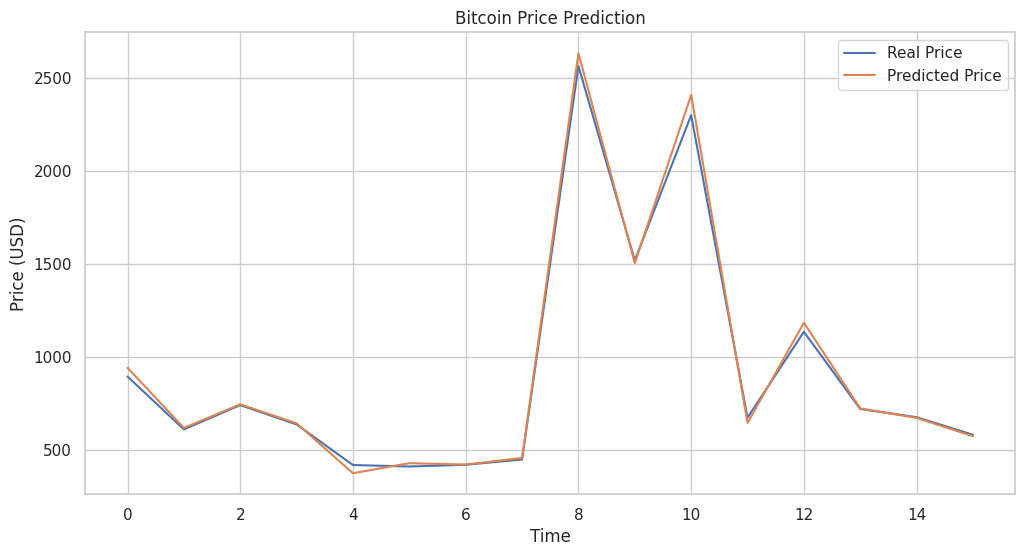

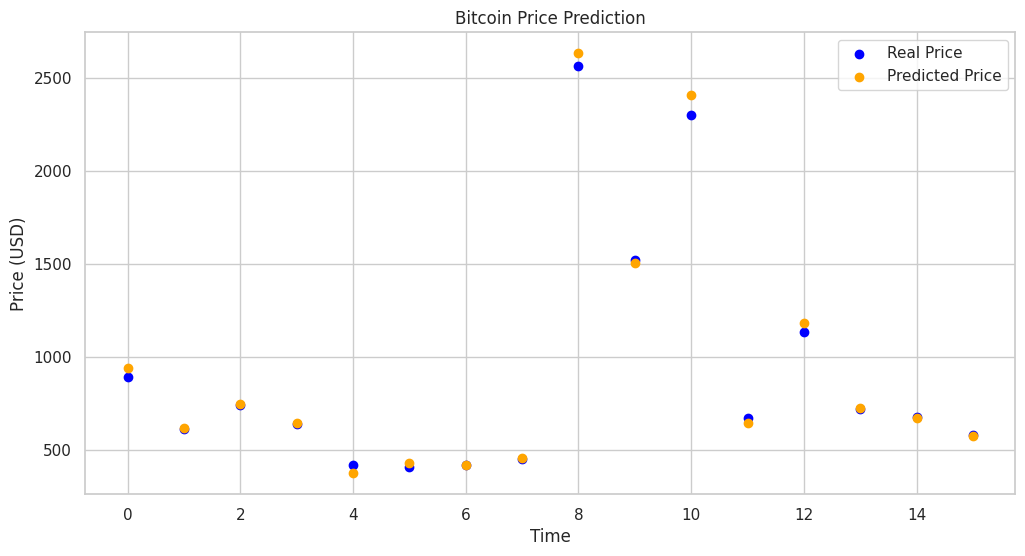

,Real Price,Predicted Price
0,895.69,942.88
1,612.15,619.80
2,742.20,746.75
3,638.59,644.39
4,420.62,376.56
5,412.78,430.59
6,421.91,423.15
7,450.55,458.55
8,2562.79,2631.52
9,1519.41,1504.66


Mean Squared Error (MSE): 1536.0063826417534
Root Mean Squared Error (RMSE): 39.19191731265202
Mean Absolute Error (MAE): 26.221155963501865
R² Score: 0.9961957820722461


In [290]:
predicted_prices, real_prices = inverse_transform_predictions(predictions, testY, scaler, nb_features=trainX.shape[2])
show_results(predicted_prices, real_prices)

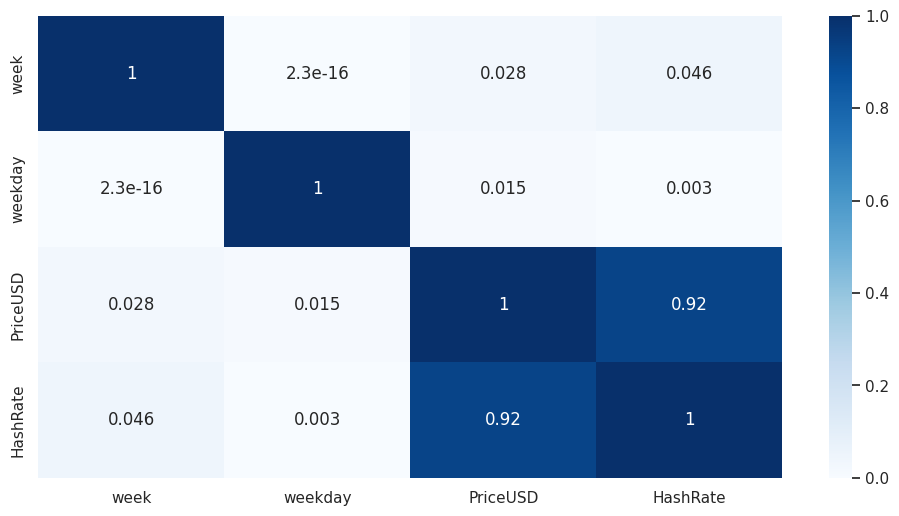

In [291]:
df = pd.read_csv('../data/timeseries/task1/external.csv')
global_df = pd.read_csv('../data/timeseries/task1/global.csv')

corr = df.corr()

# plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()